In [2]:
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(42)
# Define the Hindmarsh-Rose neuron model
def hr_neuron_model(state, t, I, r):
    x, y, z = state
    dxdt = y + 3 * x**2 - x**3 - z + I
    dydt = 1 - 5 * x**2 - y
    dzdt = r * (4 * (x + 8/5) - z)
    return [dxdt, dydt, dzdt]


In [3]:

# Initialize the Echo State Network (ESN) class
class EchoStateNetwork:
    def __init__(self, N_res, p, alpha, rho):
        self.N_res = N_res
        self.p = p
        self.alpha = alpha
        self.rho = rho
        self.Win = np.random.uniform(-0.5, 0.5, (N_res, 1))
        self.Wres = self.initialize_reservoir(N_res, p, rho)
        self.Wout = None

    def initialize_reservoir(self, N_res, p, rho):
        W = np.random.rand(N_res, N_res) - 0.5
        mask = np.random.rand(N_res, N_res) < p
        W *= mask
        spectral_radius = np.max(np.abs(np.linalg.eigvals(W)))
        W *= rho / spectral_radius
        return W

    def train(self, u, y_target):
        states = np.zeros((len(u), self.N_res))
        state = np.zeros(self.N_res)
        for t in range(1, len(u)):
            state = (1 - self.alpha) * state + self.alpha * np.tanh(np.dot(self.Wres, state) + self.Win.flatten() * u[t])
            states[t] = state
        reg = Ridge(alpha=1e-6)
        reg.fit(states, y_target)
        self.Wout = reg.coef_

    def predict(self, u):
        states = np.zeros((len(u), self.N_res))
        state = np.zeros(self.N_res)
        y_pred = np.zeros(len(u))
        for t in range(1, len(u)):
            state = (1 - self.alpha) * state + self.alpha * np.tanh(np.dot(self.Wres, state) + self.Win.flatten() * u[t])
            states[t] = state
            y_pred[t] = np.dot(self.Wout, state)
        return y_pred


In [ ]:

# Simulation and ESN setup parameters
I, r = 3.34, 0.003  # Control parameters
t = np.arange(0, 1500, 0.005)
initial_state = [-1.0, 2.0, 0.5]

# Solve the HR model
solution = odeint(hr_neuron_model, initial_state, t, args=(I, r))
x = solution[:, 0]  # Extract membrane potential

# Normalize the data
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x.reshape(-1, 1)).flatten()

# Setting up the Echo State Network
N_res = 900
p = 0.875
alpha = 0.5
rho = 0.85
esn = EchoStateNetwork(N_res, p, alpha, rho)


In [ ]:

# Warm-up times
N_warmup1 = 40000  # First warm-up time
N_warmup2 = 200000  # Second warm-up time (example of a later time showing significant changes)

# Train and predict for T1
esn.train(x_normalized[:N_warmup1-1], x_normalized[1:N_warmup1])
predicted_T1 = esn.predict(x_normalized)
predicted_denormalized_T1 = scaler.inverse_transform(predicted_T1.reshape(-1, 1)).flatten()

# Train and predict for T2
esn.train(x_normalized[:N_warmup2-1], x_normalized[1:N_warmup2])
predicted_T2 = esn.predict(x_normalized)
predicted_denormalized_T2 = scaler.inverse_transform(predicted_T2.reshape(-1, 1)).flatten()


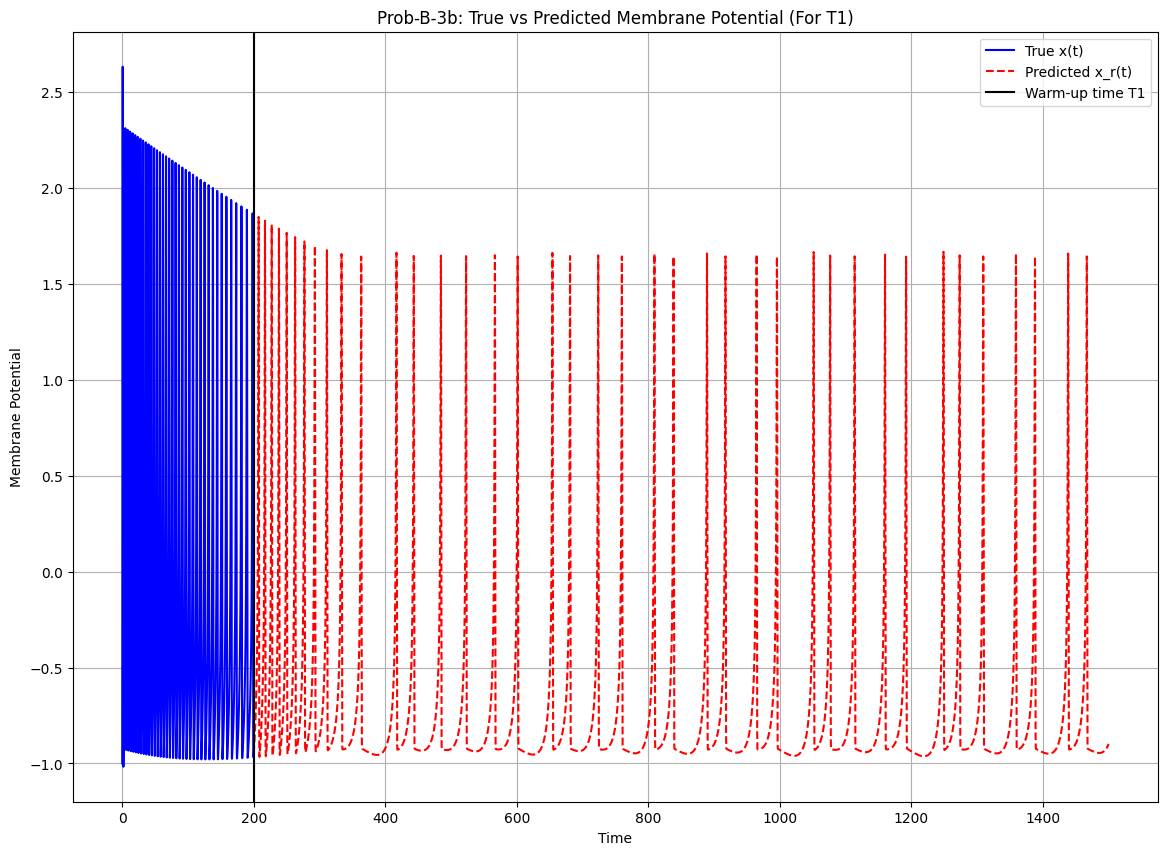

In [ ]:

# Plot original vs predicted for warm-up time T1
plt.figure(figsize=(14, 10))
plt.plot(t[:N_warmup1], x[:N_warmup1], label='True x(t)', color='blue')
plt.plot(t[N_warmup1:], predicted_denormalized_T1[N_warmup1:], label='Predicted x_r(t)', linestyle='--', color='red')
plt.axvline(x=t[N_warmup1], label='Warm-up time T1', color='black', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.title('Prob-B-3b: True vs Predicted Membrane Potential (For T1)')
plt.legend()
plt.grid(True)
plt.savefig('Prob-B-3b_T1.png')
plt.show()



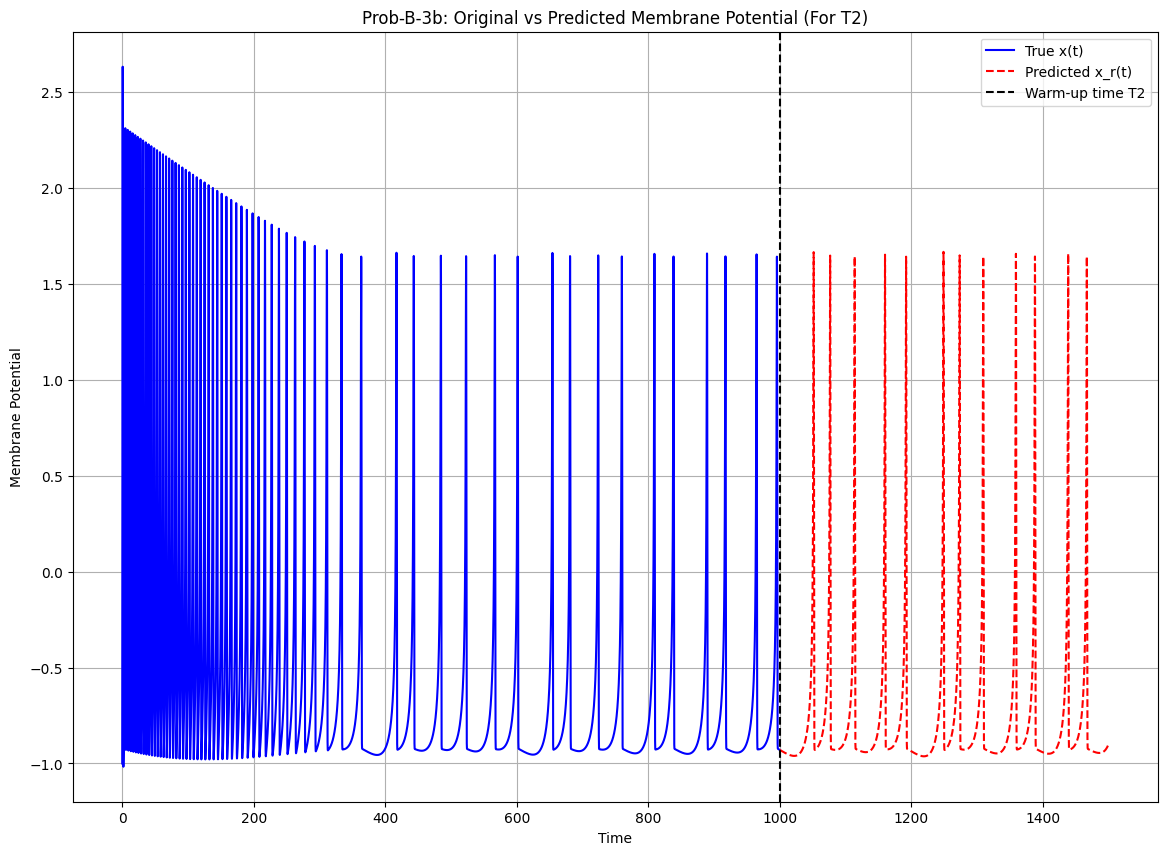

In [ ]:

# Plot original vs predicted for warm-up time T2
plt.figure(figsize=(14, 10))
plt.plot(t[:N_warmup2], x[:N_warmup2], label='True x(t)', color='blue')
plt.plot(t[N_warmup2:], predicted_denormalized_T2[N_warmup2:], label='Predicted x_r(t)', linestyle='--', color='red')
plt.axvline(x=t[N_warmup2], label='Warm-up time T2', color='black', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.title('Prob-B-3b: Original vs Predicted Membrane Potential (For T2)')
plt.legend()
plt.grid(True)
plt.savefig('Prob-B-3b_T2.png')
plt.show()